## MLP: Initializations

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNISt_data/", one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNISt_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNISt_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNISt_data/t10k-images-idx3-ubyte.gz
Extracting MNISt_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, y, y_1, ax, ticks, title, colors=['b']):
    ax.plot(x, y, 'b', label='Train Loss')
    ax.plot(x, y_1, 'r', label='Test Loss')
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [14]:
#Network Parameters
n_hidden_1 = 512 #!st Layer number of neurons
n_hidden_2 = 128 #2nd Layer number of neurons
n_hidden_3 = 64 #2nd Layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [15]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32,[None, 10])

#keep_prob : we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)

#keep_prob_input : we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [16]:
# weight initialization

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# https://www.tensorflow.org/api_docs/python/tf/random_normal
# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# h3 =>  σ=√(2/(fan_in+fan_out+1) = 0.101  => N(0,σ) = N(0,0.101)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.163  => N(0,σ) = N(0,0.163)
# SGD: Xavier/Glorot Normal initialization.

weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039,mean=0)), #784x512 #sqrt(2/(784+512)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)), #512X128 # sqrt(2/512+128) = 0.055
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.102, mean=0)), #128X64 # sqrt(2/128+64) = 0.102
    'out' : tf.Variable(tf.random_normal([n_hidden_3, n_classes],stddev=0.164, mean=0)) #64X10 # sqrt(2/64+10) = 0.164
}

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.050  => N(0,σ) = N(0,0.050)
# h2 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h3 =>  σ=√(2/(fan_in+1) = 0.124  => N(0,σ) = N(0,0.124)
# out =>  σ=√(2/(fan_in+1) = 0.175  => N(0,σ) = N(0,0.175)
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.050,mean=0)),     #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.062, mean=0)),  #512X128
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.124, mean=0)),  #128X64
    'out' : tf.Variable(tf.random_normal([n_hidden_3, n_classes],stddev=0.175, mean=0)) #64X10
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])), #512X1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])), #128X1
    'b3': tf.Variable(tf.random_normal([n_hidden_3])), #64X1
    'out' : tf.Variable(tf.random_normal([n_classes])) #10X1
}

In [17]:
#Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

<h3> Model 1: input (784) - sigmoid(512) - sigmoid(128) - sigmoid(64) -
softmax(output 10) </h3>

In [18]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())
    
     # Hidden layer with Sigmoid activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_2 * weights['h3']) + biases['b3'] 
    layer_3 = tf.nn.sigmoid(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_3 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 1 + AdamOptimizer __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b3: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


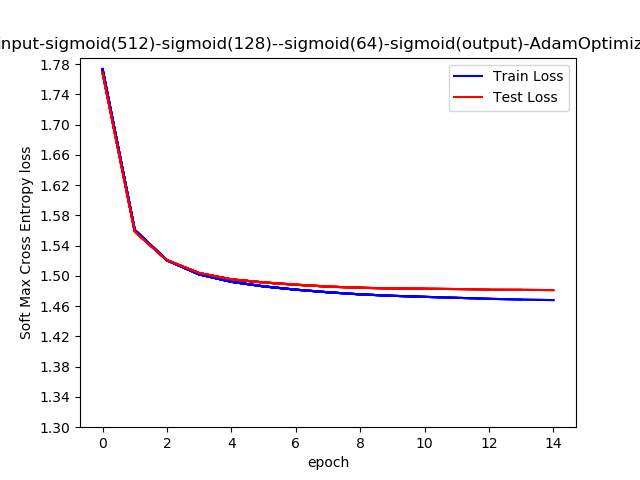

Epoch: 0001 train cost=1.773315148 test cost=1.769213455
Epoch: 0002 train cost=1.560591423 test cost=1.558728723
Epoch: 0003 train cost=1.520618233 test cost=1.520758172
Epoch: 0004 train cost=1.501981009 test cost=1.503722608
Epoch: 0005 train cost=1.492200061 test cost=1.495422597
Epoch: 0006 train cost=1.486167994 test cost=1.491359627
Epoch: 0007 train cost=1.481808462 test cost=1.488353512
Epoch: 0008 train cost=1.478353986 test cost=1.485868464
Epoch: 0009 train cost=1.475604780 test cost=1.484344465
Epoch: 0010 train cost=1.473690291 test cost=1.483351589
Epoch: 0011 train cost=1.472313739 test cost=1.483037641
Epoch: 0012 train cost=1.471028117 test cost=1.482614791
Epoch: 0013 train cost=1.469753741 test cost=1.481825974
Epoch: 0014 train cost=1.468717548 test cost=1.481688634
Epoch: 0015 train cost=1.467999111 test cost=1.481142612
Accuracy: 0.9781


In [19]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)--sigmoid(64)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(64)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

<IPython.core.display.Javascript object>


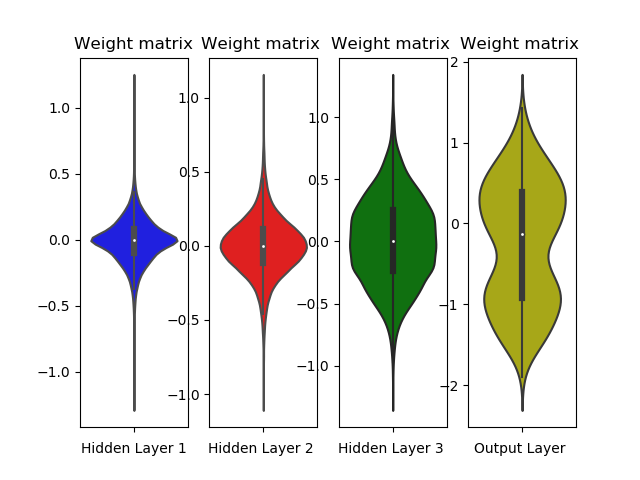

In [20]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer __

<IPython.core.display.Javascript object>


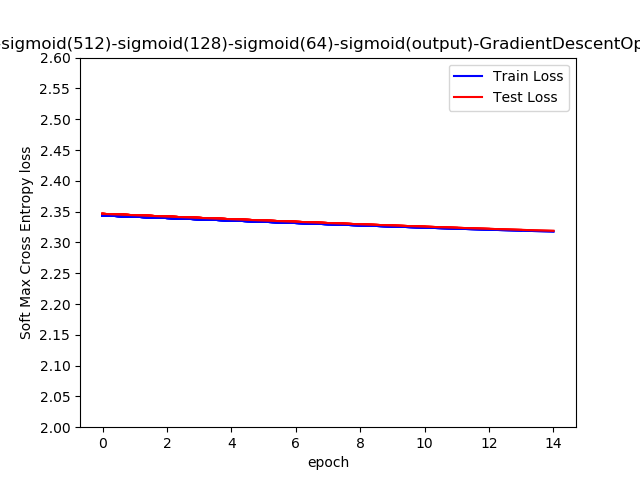

Epoch: 0001 train cost=2.343715186 test cost=2.346278050
Epoch: 0002 train cost=2.341638766 test cost=2.344094772
Epoch: 0003 train cost=2.339575116 test cost=2.341922645
Epoch: 0004 train cost=2.337525933 test cost=2.339773908
Epoch: 0005 train cost=2.335495263 test cost=2.337620570
Epoch: 0006 train cost=2.333486818 test cost=2.335523631
Epoch: 0007 train cost=2.331505268 test cost=2.333449113
Epoch: 0008 train cost=2.329558102 test cost=2.331395758
Epoch: 0009 train cost=2.327654184 test cost=2.329350162
Epoch: 0010 train cost=2.325800296 test cost=2.327428698
Epoch: 0011 train cost=2.324003288 test cost=2.325533856
Epoch: 0012 train cost=2.322274985 test cost=2.323693883
Epoch: 0013 train cost=2.320624127 test cost=2.321981273
Epoch: 0014 train cost=2.319059235 test cost=2.320318881
Epoch: 0015 train cost=2.317586588 test cost=2.318771316
Accuracy: 0.098


In [21]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(64)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(64)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

<IPython.core.display.Javascript object>


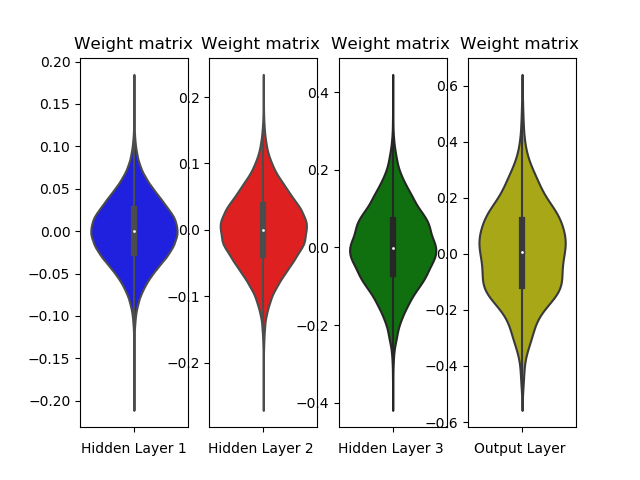

In [22]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 2: input (784) - ReLu(512) - ReLu(128) - ReLu(64)-sigmoid(output 10) </h3>

In [23]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b[h3]:', biases['b3'].get_shape()) 
    
     # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_2 * weights['h3']) + biases['b3'] 
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape()) 
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_3 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Input-ReLu(512)-ReLu(128)-ReLu(64)-sigmoid(output) - AdamOptimizer  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (64, 10) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


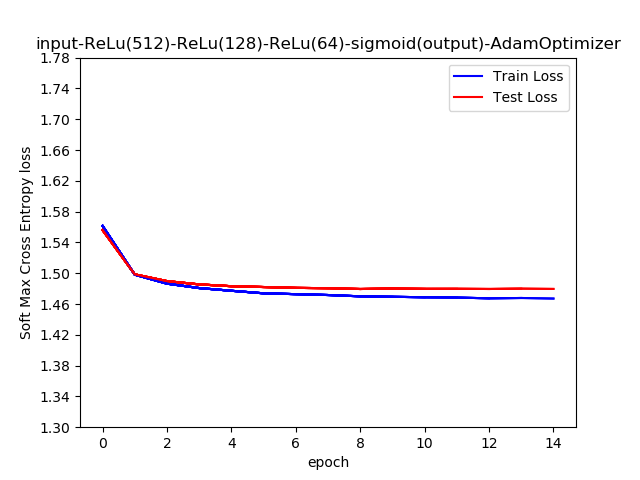

Epoch: 0001 train cost=1.561466937 test cost=1.556067030
Epoch: 0002 train cost=1.498106880 test cost=1.498497529
Epoch: 0003 train cost=1.486428372 test cost=1.489730705
Epoch: 0004 train cost=1.480691684 test cost=1.485469187
Epoch: 0005 train cost=1.477187046 test cost=1.483112200
Epoch: 0006 train cost=1.473879424 test cost=1.482041611
Epoch: 0007 train cost=1.472788581 test cost=1.480938535
Epoch: 0008 train cost=1.471660674 test cost=1.480517388
Epoch: 0009 train cost=1.469965397 test cost=1.479481284
Epoch: 0010 train cost=1.469399309 test cost=1.480165217
Epoch: 0011 train cost=1.468725230 test cost=1.479676712
Epoch: 0012 train cost=1.468431786 test cost=1.479717243
Epoch: 0013 train cost=1.467315576 test cost=1.479501660
Epoch: 0014 train cost=1.467805587 test cost=1.479980413
Epoch: 0015 train cost=1.467060892 test cost=1.479573437
Accuracy: 0.9789


In [24]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-ReLu(64)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-ReLu(64)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

<IPython.core.display.Javascript object>


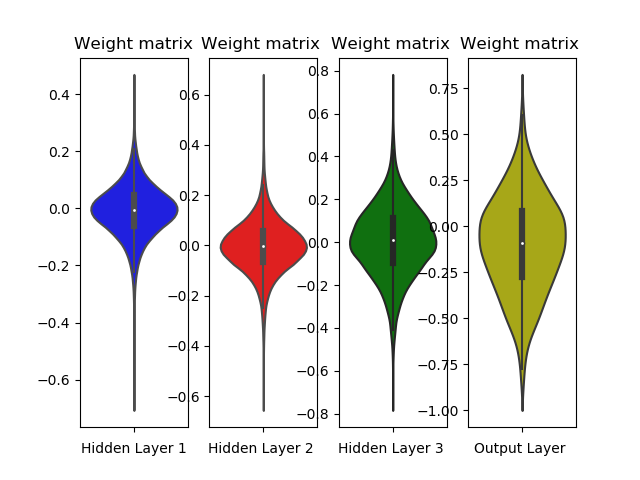

In [25]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Input-ReLu(512)-ReLu(128)-sigmoid(output) - GradientDescentOptimizer__

<IPython.core.display.Javascript object>


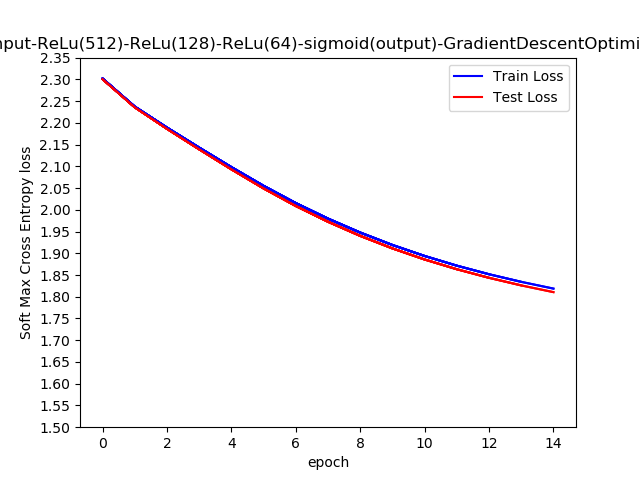

Epoch: 0001 train cost=2.301764066 test cost=2.300602700
Epoch: 0002 train cost=2.237219031 test cost=2.235782214
Epoch: 0003 train cost=2.188970261 test cost=2.186320178
Epoch: 0004 train cost=2.142925598 test cost=2.139228865
Epoch: 0005 train cost=2.098049096 test cost=2.093204775
Epoch: 0006 train cost=2.055048820 test cost=2.049231397
Epoch: 0007 train cost=2.015386188 test cost=2.008790748
Epoch: 0008 train cost=1.979687937 test cost=1.972509209
Epoch: 0009 train cost=1.947643434 test cost=1.940010485
Epoch: 0010 train cost=1.919061382 test cost=1.911187216
Epoch: 0011 train cost=1.893772536 test cost=1.885677945
Epoch: 0012 train cost=1.871475279 test cost=1.863267662
Epoch: 0013 train cost=1.851756208 test cost=1.843516515
Epoch: 0014 train cost=1.834277184 test cost=1.826079872
Epoch: 0015 train cost=1.818749594 test cost=1.810604771
Accuracy: 0.7697


In [26]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-ReLu(64)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-ReLu(64)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

<IPython.core.display.Javascript object>


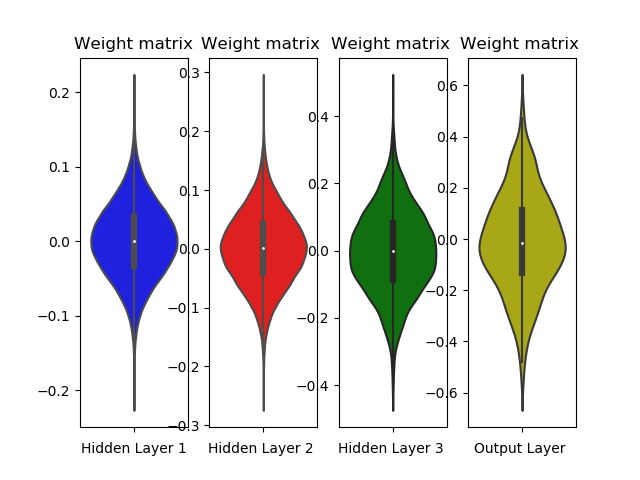

In [27]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 3: Input - Sigmoid(BatchNormalization(512)) - Sigmoid(BatchNormalization(128))- Sigmoid(output) </h3>

In [28]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    ######################################################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_2 * weights['h3']) + biases['b3'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, beta_3, scale_3, epsilon)
    layer_3 = tf.nn.sigmoid(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape()) 
    
    ######################################################################################
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_3 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 3+ AdamOptimizer  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Instructions for updating:
Use tf.cast instead.


<IPython.core.display.Javascript object>


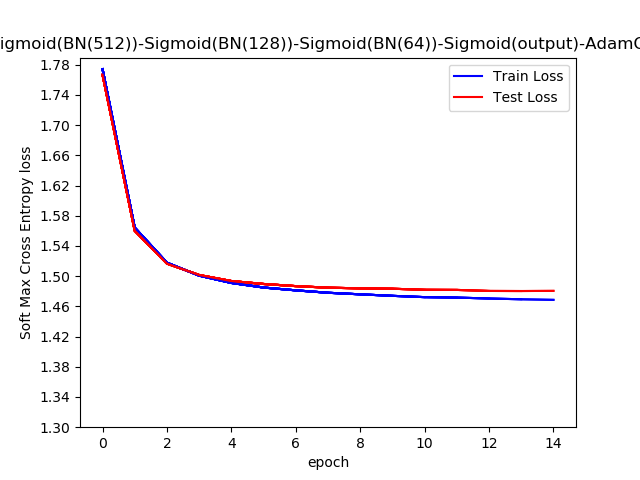

Epoch: 0001 train cost=1.774159985 test cost=1.766693340
Epoch: 0002 train cost=1.564224076 test cost=1.560092255
Epoch: 0003 train cost=1.517827334 test cost=1.516624630
Epoch: 0004 train cost=1.500708572 test cost=1.501533414
Epoch: 0005 train cost=1.491022325 test cost=1.493566585
Epoch: 0006 train cost=1.484947199 test cost=1.489662491
Epoch: 0007 train cost=1.481224123 test cost=1.486831712
Epoch: 0008 train cost=1.478034270 test cost=1.484755150
Epoch: 0009 train cost=1.475958028 test cost=1.483878313
Epoch: 0010 train cost=1.473966236 test cost=1.483367330
Epoch: 0011 train cost=1.472242816 test cost=1.481966401
Epoch: 0012 train cost=1.471650541 test cost=1.481794877
Epoch: 0013 train cost=1.470419061 test cost=1.480426541
Epoch: 0014 train cost=1.469393709 test cost=1.480322153
Epoch: 0015 train cost=1.468638888 test cost=1.480543164
Accuracy: 0.9794


In [29]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

<IPython.core.display.Javascript object>


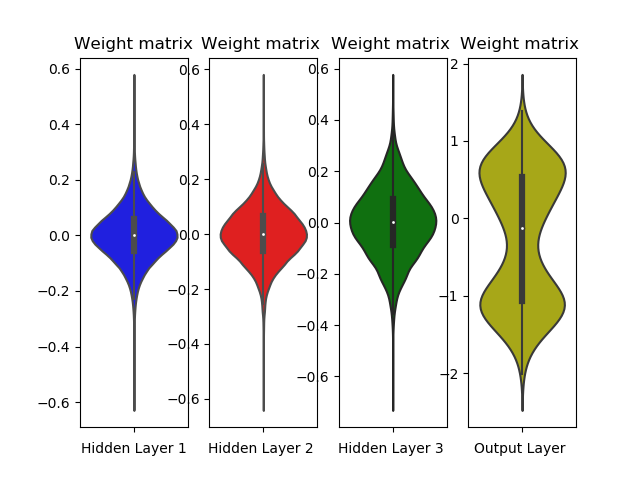

In [30]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer  __

<IPython.core.display.Javascript object>


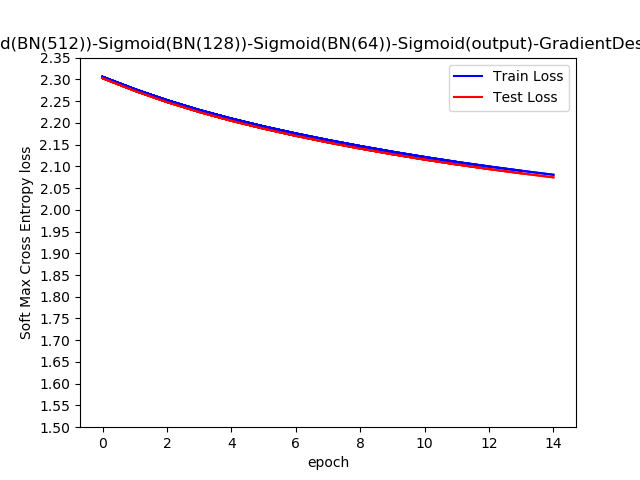

Epoch: 0001 train cost=2.305746552 test cost=2.302859496
Epoch: 0002 train cost=2.277413382 test cost=2.273822009
Epoch: 0003 train cost=2.252050128 test cost=2.247905862
Epoch: 0004 train cost=2.229589054 test cost=2.225116605
Epoch: 0005 train cost=2.209705620 test cost=2.204853852
Epoch: 0006 train cost=2.191826024 test cost=2.186755768
Epoch: 0007 train cost=2.175539862 test cost=2.170235925
Epoch: 0008 train cost=2.160496505 test cost=2.155036350
Epoch: 0009 train cost=2.146551846 test cost=2.140889674
Epoch: 0010 train cost=2.133516790 test cost=2.127763994
Epoch: 0011 train cost=2.121419961 test cost=2.115506101
Epoch: 0012 train cost=2.110035631 test cost=2.104200299
Epoch: 0013 train cost=2.099608003 test cost=2.093610472
Epoch: 0014 train cost=2.089821201 test cost=2.083813038
Epoch: 0015 train cost=2.080557715 test cost=2.074576798
Accuracy: 0.437


In [31]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))Sigmoid(BN(64))-Sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

<IPython.core.display.Javascript object>


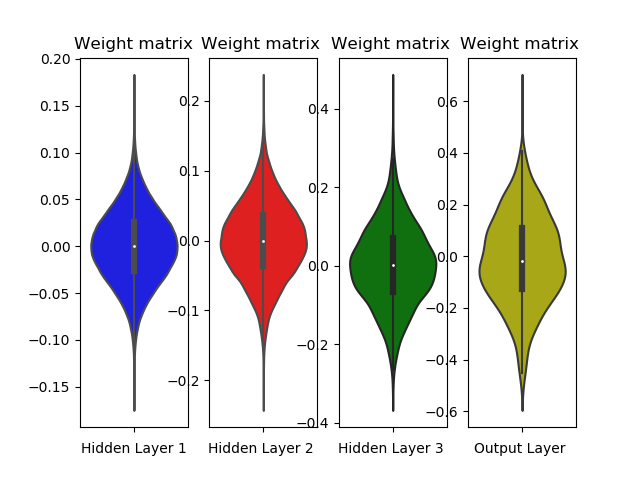

In [32]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 4: Input - ReLu(512) - Dropout - ReLu(128)- ReLu(64)-Dropout -Sigmoid(output) </h3>

In [33]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape()) 
    
    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2_drop, weights['h3']), biases['b3']) # (layer_2 * weights['h3']) + biases['b3'] 
    layer_3 = tf.nn.relu(layer_3)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_3_drop = tf.nn.dropout(layer_3, keep_prob)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape()) 
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_3_drop, weights['out']) + biases['out'] # (layer_3 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 4 + AdamOptimizer __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


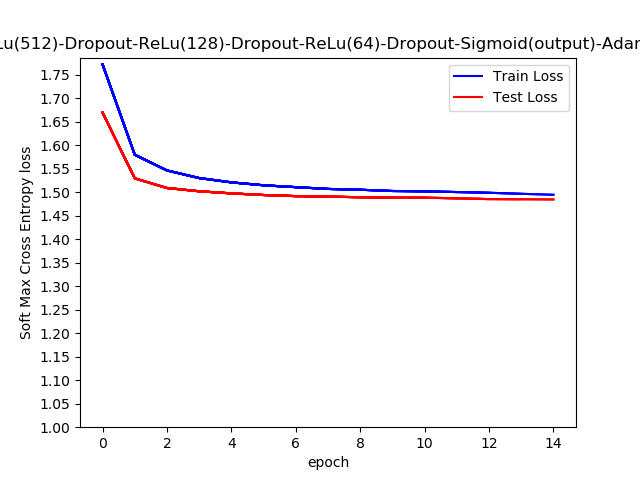

Epoch: 0001 train cost=1.771692866 test cost=1.669158272
Epoch: 0002 train cost=1.579444002 test cost=1.529193089
Epoch: 0003 train cost=1.546061877 test cost=1.508736135
Epoch: 0004 train cost=1.529864551 test cost=1.501780253
Epoch: 0005 train cost=1.520698632 test cost=1.497305176
Epoch: 0006 train cost=1.514503698 test cost=1.493821695
Epoch: 0007 train cost=1.510535555 test cost=1.491474242
Epoch: 0008 train cost=1.506744935 test cost=1.490389285
Epoch: 0009 train cost=1.505010543 test cost=1.489071041
Epoch: 0010 train cost=1.502341919 test cost=1.488187912
Epoch: 0011 train cost=1.501564102 test cost=1.488104806
Epoch: 0012 train cost=1.500118958 test cost=1.486784578
Epoch: 0013 train cost=1.498580928 test cost=1.485135313
Epoch: 0014 train cost=1.496378089 test cost=1.484777141
Epoch: 0015 train cost=1.494318264 test cost=1.484310180
Accuracy: 0.9718


In [34]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

<IPython.core.display.Javascript object>


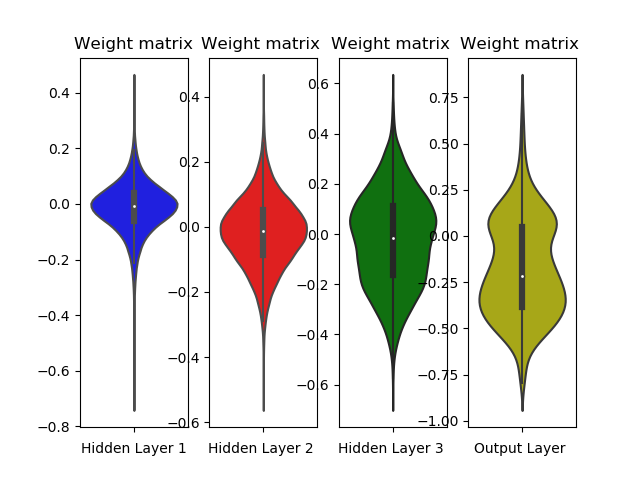

Text(0.5,0,'Output Layer ')

In [35]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='g')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()